<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TSA_Nifty_50_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'''
Libraries that were installed

pip install pandas
pip install matplotlib
pip install statsmodels

pip install scikit-learn
m
'''


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsforecast import StatsForecast

In [ ]:
### Reading the training data using pandas
### Setting date as the index field

df = pd.read_csv('NIFTY_50_2015-2023.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


df.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,
2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15


In [ ]:
# Check for missing dates and add them to the dataset
# Identify Start and End dates from the dataset and generate new dates from those dates which will be daily dates

start = df.index[0].date()
end = df.index[len(df)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')

# Re-indexing new dates with the old dates

df = df.reindex(new_dates)
df = df.rename_axis('Fin_Dt')
df.reset_index(inplace=True)
df = df.ffill()

df['Date'] = pd.to_datetime(df['Fin_Dt'])
df.set_index('Date', inplace=True)

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55


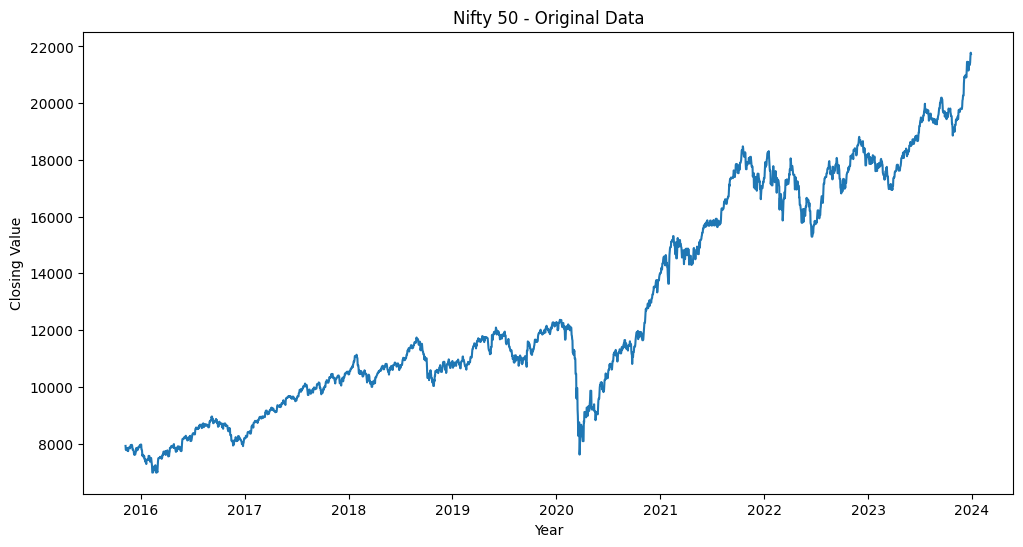

In [ ]:
# Use the 'Close' prices as the target variable and plot the Original Data
final_data = df[['Fin_Dt','Close']]

close_plot = final_data['Close']

plt.figure(figsize=(12, 6))
plt.plot(close_plot)
plt.title("Nifty 50 - Original Data")
plt.xlabel("Year")
plt.ylabel("Closing Value")
plt.show()


In [ ]:
## Check if the data is stationary. Here we used Augmented Dickey Fuller's test
## But, this test tells us if there is a change in the Mean with absolute time.
## But, it doesnt tell us if the Variance is dependent on absolute time or is it dependent on the lag

# Perform the ADF test
adf_res = adfuller(df['Close'], autolag='AIC')
print(f"ADF Statistic: {adf_res[0]}")
print(f"p-value: {adf_res[1]}")
print(f"No Lags Used: {adf_res[2]}")
print(f"Number of observations used: {adf_res[3]}")
print(f"Critical Values: {adf_res[4]}")

if adf_res[1] <= 0.05:
    print("Reject the null hypothesis")
    print("The data is stationary")

else:
    print("The null hypothesis cannot be rejected")
    print("The data is not stationary")

ADF Statistic: 0.28403568735129103
p-value: 0.9766000806277764
No Lags Used: 13
Number of observations used: 2959
Critical Values: {'1%': np.float64(-3.432561889805549), '5%': np.float64(-2.862517267814074), '10%': np.float64(-2.5672902261937134)}
The null hypothesis cannot be rejected
The data is not stationary


Since the p-value is greater than 0.05, we fail to reject the null hypothesis, which means the data is not stationary.
Lets do the first order differencing of the data to remove the varying Mean component. Below are the different ways we can use to remove the varying mean and variance components.

Differencing: Subtracting the current observation from the previous one to achieve stationarity.
Detrending: Another technique for removing seasonality from time series data.
Seasonal decomposition: Decomposing the time series into seasonal, trend, and residual components.
Log transformation: Taking the natural logarithm of the data to stabilize variance.
Log difference: Combining log transformation and differencing to address both trend and seasonali

Lets go with log difference.

But before we go, lets plot seasonal adjusted timeseries and differenced timeseries data along with the original data.ty.

In [ ]:
# Seasonal adjustment
# seasonal_res = seasonal_decompose(final_data['Close'], model='additive', period=7)
# df['Seasonal_Adjusted'] = seasonal_res.resid

df['Seasonal_Adjusted'] = df['Close'].diff(periods=12).dropna()

# Differencing
df['Differenced'] = df['Close'].diff().dropna()

# Log Differencing

df['Log_Differenced'] = np.log(df['Close']/df['Close'].shift(1)).dropna()

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051


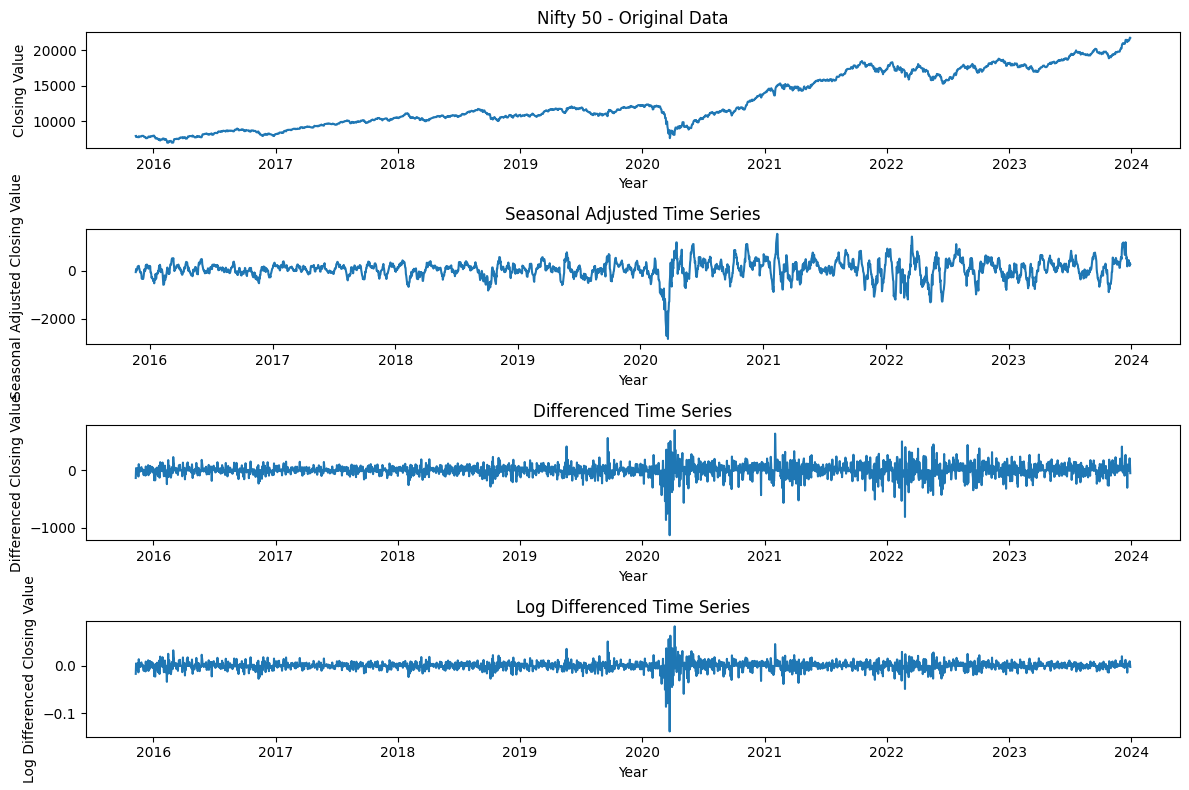

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(close_plot)
plt.title('Nifty 50 - Original Data')
plt.xlabel('Year')
plt.ylabel('Closing Value')

# Seasonal Adjusted
plt.subplot(4, 1, 2)
plt.plot(df['Seasonal_Adjusted'])
plt.title('Seasonal Adjusted Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Adjusted Closing Value')

# Differenced
plt.subplot(4, 1, 3)
plt.plot(df['Differenced'])
plt.title('Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Differenced Closing Value')

# Log Differenced
plt.subplot(4, 1, 4)
plt.plot(df['Log_Differenced'])
plt.title('Log Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Log Differenced Closing Value')

plt.tight_layout()
plt.show()

The differenced data has approximately more or less constant mean when we apply windows and see.

But, lets calculate the ADF value again to re-confirm

In [ ]:
# Perform the ADF test
# adf_res_mod = adfuller(df['Log_Differenced'].dropna())
adf_res_mod = adfuller(df['Log_Differenced'].dropna(), autolag='AIC')
print(f"ADF Statistic: {adf_res_mod[0]}")
print(f"p-value: {adf_res_mod[1]}")
print(f"#Lags Used: {adf_res_mod[2]}")
print(f"Number of Observations Used: {adf_res_mod[3]}")
print(f"Critical Values: {adf_res_mod[4]}")

# Perform the ADF test
adf_res_mod = adfuller(df['Differenced'].dropna())
print(f"ADF Statistic: {adf_res_mod[0]}")
print(f"p-value: {adf_res_mod[1]}")
print(f"#Lags Used: {adf_res_mod[2]}")
print(f"Number of Observations Used: {adf_res_mod[3]}")
print(f"Critical Values: {adf_res_mod[4]}")

# Perform the ADF test
adf_res_mod = adfuller(df['Seasonal_Adjusted'].dropna())
print(f"ADF Statistic: {adf_res_mod[0]}")
print(f"p-value: {adf_res_mod[1]}")
print(f"#Lags Used: {adf_res_mod[2]}")
print(f"Number of Observations Used: {adf_res_mod[3]}")
print(f"Critical Values: {adf_res_mod[4]}")

ADF Statistic: -13.189326843564611
p-value: 1.1526911463038172e-24
#Lags Used: 14
Number of Observations Used: 2957
Critical Values: {'1%': np.float64(-3.432563387143659), '5%': np.float64(-2.8625179291294662), '10%': np.float64(-2.5672905782716513)}
ADF Statistic: -13.895226266266183
p-value: 5.868297702786328e-26
#Lags Used: 12
Number of Observations Used: 2959
Critical Values: {'1%': np.float64(-3.432561889805549), '5%': np.float64(-2.862517267814074), '10%': np.float64(-2.5672902261937134)}
ADF Statistic: -7.634902756655264
p-value: 1.96417340008391e-11
#Lags Used: 28
Number of Observations Used: 2932
Critical Values: {'1%': np.float64(-3.4325822763786977), '5%': np.float64(-2.8625262717336724), '10%': np.float64(-2.5672950197984696)}


The p-value obtained is less than the significance level of 0.05, and the ADF statistic is less than any of the critical values.
we reject the Null hypothesis in favor of the alternative. So, the time series is, in fact, stationary

In [ ]:
## KPSS Method (Opposite of ADF)

kpsstest = kpss(df['Log_Differenced'].dropna(), regression='c', nlags="auto")
print(f"KPSS Statistic: {kpsstest[0]}")
print(f"p-value: {kpsstest[1]}")
print(f"#Lags Used: {kpsstest[2]}")
print(f"Critical Values: {kpsstest[3]}")

kpsstest = kpss(df['Differenced'].dropna(), regression='c', nlags="auto")
print(f"KPSS Statistic: {kpsstest[0]}")
print(f"p-value: {kpsstest[1]}")
print(f"#Lags Used: {kpsstest[2]}")
print(f"Critical Values: {kpsstest[3]}")

kpsstest = kpss(df['Seasonal_Adjusted'].dropna(), regression='c', nlags="auto")
print(f"KPSS Statistic: {kpsstest[0]}")
print(f"p-value: {kpsstest[1]}")
print(f"#Lags Used: {kpsstest[2]}")
print(f"Critical Values: {kpsstest[3]}")

KPSS Statistic: 0.05692267921622604
p-value: 0.1
#Lags Used: 2
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS Statistic: 0.17804955434536518
p-value: 0.1
#Lags Used: 1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS Statistic: 0.15232750310501367
p-value: 0.1
#Lags Used: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\mouni\AppData\Local\Temp\ipykernel_26476\174637339.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(df['Log_Differenced'].dropna(), regression='c', nlags="auto")
C:\Users\mouni\AppData\Local\Temp\ipykernel_26476\174637339.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(df['Differenced'].dropna(), regression='c', nlags="auto")
C:\Users\mouni\AppData\Local\Temp\ipykernel_26476\174637339.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(df['Seasonal_Adjusted'].dropna(), regression='c', nlags="auto")


Test Statistic < Critical Value and p-value > 0.05. As a result, we fail to reject the Null hypothesis Hence we conclude series is stationary

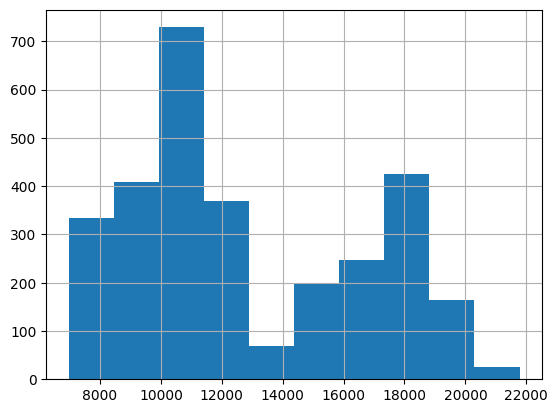

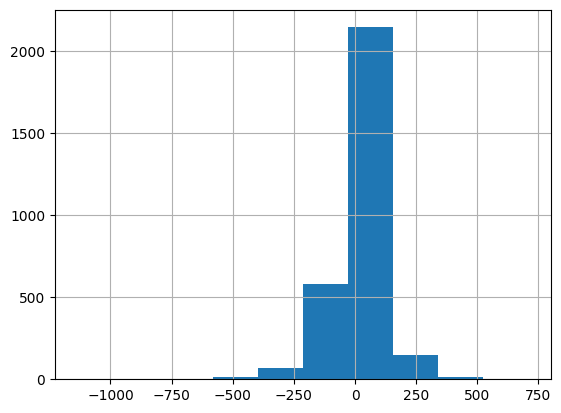

<Axes: xlabel='Date'>

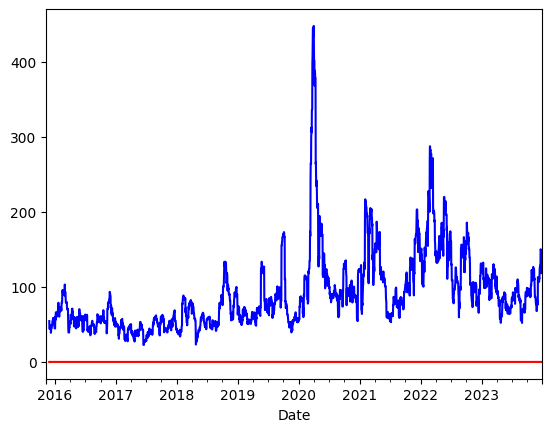

In [ ]:
final_data['Close'].hist()
plt.show()

df['Differenced'].dropna().hist()
plt.show()

## Differenced data is approximately following Guassian Distrubution

## Now lets check how is the variance. Is the differenced data stationary or not

# add the 20 day rolling standard deviation:
df['Differenced'].dropna().rolling(window=20).std().plot(style='b')

# add the 20 day rolling standard deviation:
df['Log_Differenced'].dropna().rolling(window=20).std().plot(style='r')

Lets check the frequency variance by using Welch's method using Hann windows

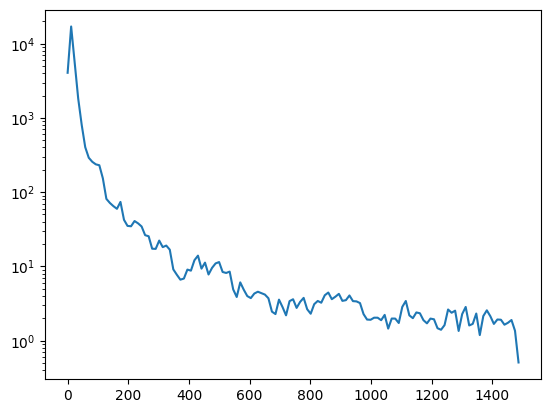

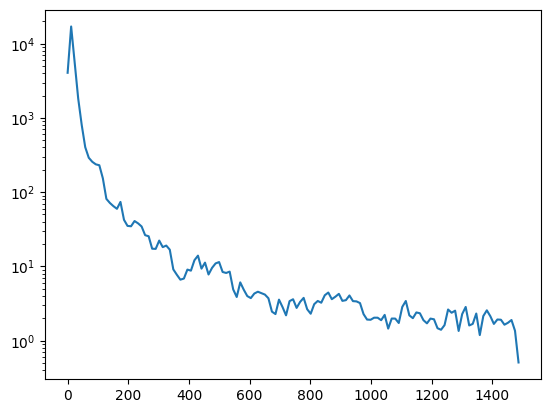

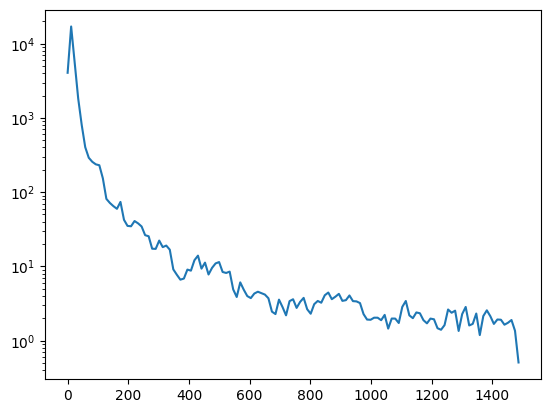

In [ ]:

f,PSD = signal.welch(df['Close'],fs=len(df['Close']), window='hann')
plt.semilogy(f,PSD)
plt.show()

f,PSD = signal.welch(df['Close'],fs=len(df['Differenced']), window='hann')
plt.semilogy(f,PSD)
plt.show()

f,PSD = signal.welch(df['Close'],fs=len(df['Log_Differenced']), window='hann')
plt.semilogy(f,PSD)
plt.show()

Lets check ACF and PACF of the differenced data

<Figure size 1200x600 with 0 Axes>

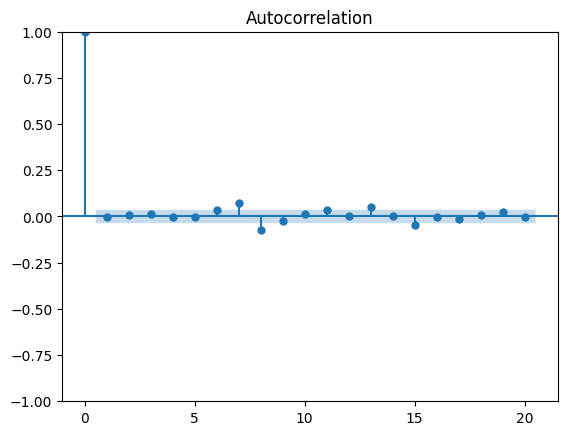

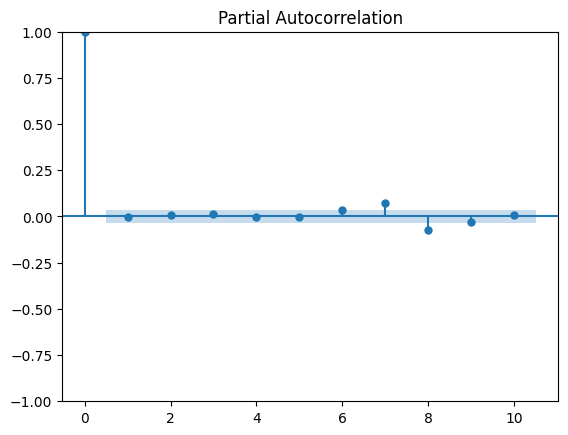

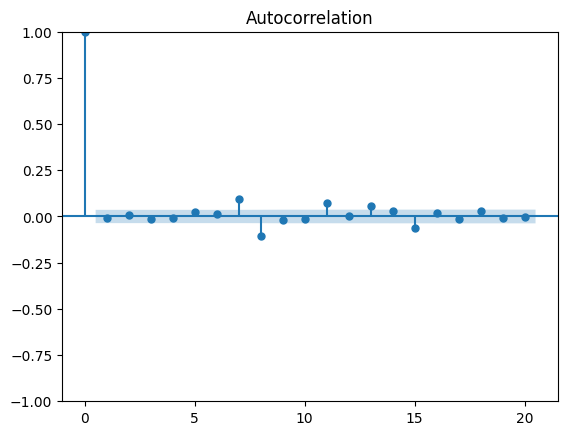

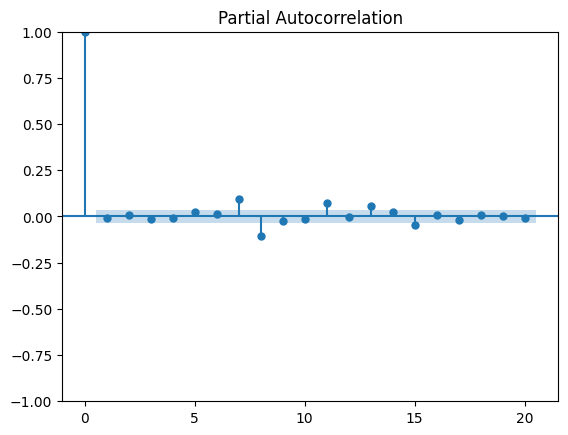

In [ ]:
# ACF and PACF of the differenced series
plt.figure(figsize=(12, 6))
plot_acf(df['Differenced'].dropna(), lags=20)
plot_pacf(df['Differenced'].dropna(), lags=10)
plot_acf(df['Log_Differenced'].dropna(), lags=20)
plot_pacf(df['Log_Differenced'].dropna(), lags=20)
plt.show()

The ACF and PACF happens to show pure white noise. Lets check AIC values as to which one will best fit for the set of models identified.

If after differencing your time series, both the ACF and PACF plots indicate only white noise, then the most likely model to identify is a simple ARIMA(0,1,0) model, which essentially represents a "random walk with drift" where the only significant component is the first difference of the data, meaning the change between consecutive observations is essentially random noise

ARIMA(0,1,0):
"0" for AR: No autoregressive component (no dependence on past values).
"1" for I: One order of differencing is required to achieve stationarity.
"0" for MA: No moving average component.

C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                 2972
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -19099.227
Date:                Wed, 25 Dec 2024   AIC                          38200.454
Time:                        10:45:40   BIC                          38206.450
Sample:                    11-10-2015   HQIC                         38202.612
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.245e+04    232.361     96.602      0.000     2.2e+04    2.29e+04
Ljung-Box (L1) (Q):                 756.22   Jarque-Bera (JB):             13991.86
Prob(Q):                              0.00   Pr

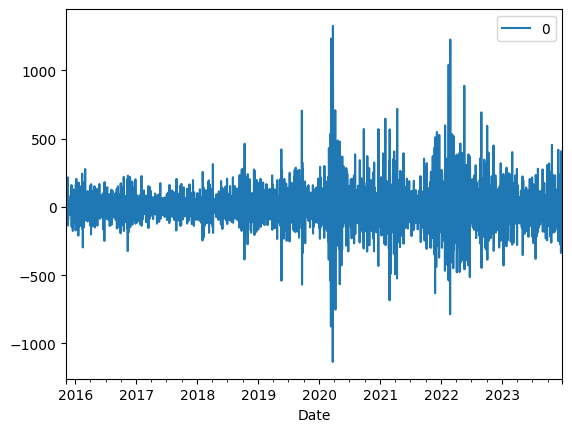

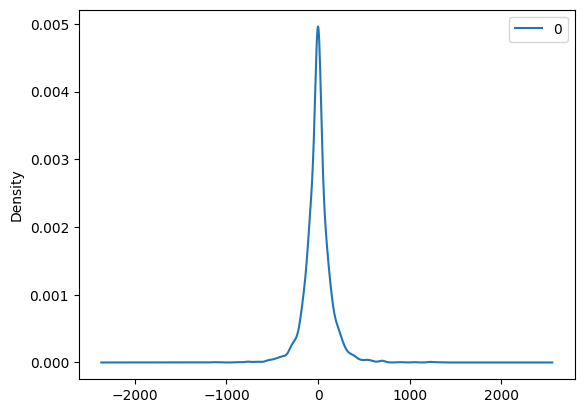

                 0
count  2972.000000
mean     -0.015915
std     149.866265
min   -1135.200000
25%     -65.050000
50%       0.000000
75%      56.700000
max    1326.000000


In [ ]:
# fit model
model = ARIMA(df['Differenced'].dropna(), order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Import Test Data

In [ ]:
# Import Test dataset

df_test = pd.read_csv('NIFTY_50_2024.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='mixed')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)


df_test.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,
2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


In [ ]:
# Check for missing dates and add them to the dataset
# Identify Start and End dates from the dataset and generate new dates from those dates which will be daily dates

start = df_test.index[0].date()
end = df_test.index[len(df_test)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')

# Re-indexing new dates with the old dates

df_test = df_test.reindex(new_dates)
df_test = df_test.rename_axis('Fin_Dt')
df_test.reset_index(inplace=True)
df_test = df_test.ffill()

df_test['Date'] = pd.to_datetime(df_test['Fin_Dt'])
df_test.set_index('Date', inplace=True)

df_test.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,,
2024-01-01,2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


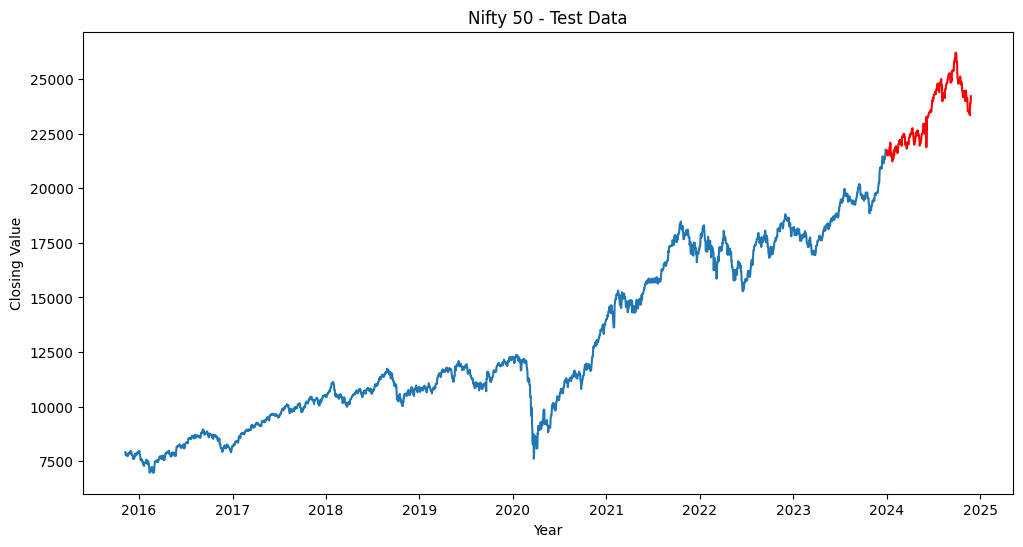

In [ ]:
# Use the 'Close' prices as the target variable and plot the Original Data
final_data_test = df_test[['Fin_Dt','Close']]

close_plot_test = final_data_test['Close']

plt.figure(figsize=(12, 6))
plt.plot(close_plot, label='Observed')
plt.plot(close_plot_test, color = 'red', label = 'Test')
plt.title("Nifty 50 - Test Data")
plt.xlabel("Year")
plt.ylabel("Closing Value")
plt.show()

Get the train and test datasets

In [ ]:
# split into train and test sets
X = df['Differenced'].dropna().values
Y = df_test['Close'].dropna().values
train, test = X, Y


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2973
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -18072.827
Date:                Wed, 25 Dec 2024   AIC                          36147.655
Time:                        10:46:10   BIC                          36153.652
Sample:                    11-09-2015   HQIC                         36149.813
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.12e+04    107.483    104.221      0.000     1.1e+04    1.14e+04
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             20769.64
Prob(Q):                              0.84   Pr

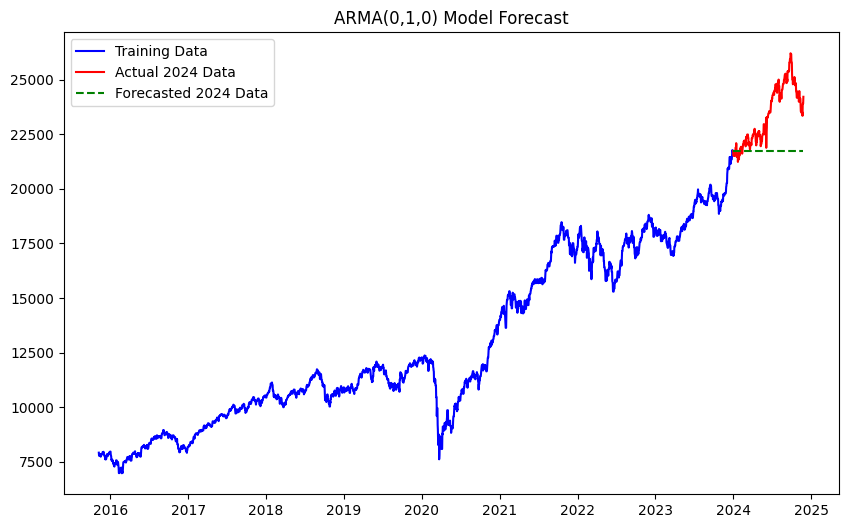

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051


In [ ]:
# Fit ARMA(0,1,0) model
model = ARIMA(df['Close'].dropna(), order=(0,1,0))
fitted_model = model.fit()
print(fitted_model.summary())

# Forecast next 20 steps
forecast = fitted_model.get_forecast(steps=330)
forecast_summary = forecast.summary_frame()

forecast_vals = fitted_model.forecast(steps=330)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=330, freq='D')

# print(forecast_vals)

# Plot forecast
# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
plt.plot(df['Close'].dropna().index, df['Close'], label='Training Data', color='blue')
plt.plot(df_test['Close'].index, df_test['Close'], label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')

#plt.plot(np.arange(len(df['Close']), len(df['Close']) + 300), forecast.predicted_mean, label="Forecast", color='orange')

plt.title("ARMA(0,1,0) Model Forecast")
plt.legend()
plt.show()

df.head()

Checking MSE and RMSE

In [ ]:
# Evaluate the model using error metrics

mae = mean_absolute_error(df_test['Close'], forecast_vals)
rmse = np.sqrt(mean_squared_error(df_test['Close'], forecast_vals))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 1694.6612121212108
Root Mean Squared Error (RMSE): 2122.564876133103


Lets choose an appropriate model by identifying AIC values for a set of models that include variations of AR, MA, ARMA, and ARIMA

Checking AIC Values for various models. There is some issue in installing auto_arima related libraries.
Hence tried manually validating AIC for sample models.

In [ ]:
## Set the initial parameters for p,d,q
p = 1
d = 1
q = 1

#AIC values to be validated until these values of p,d,q
max_p = 4
max_q = 2
max_d = 3

# print(p,d,q)

for d in range(max_d+1):
    for q in range(max_q+1):
        for p in range(max_p):
            model = ARIMA(df['Close'].dropna(), order=(p,d,q))
            fitted_model = model.fit()
            print("ARIMA Order - ", p,d,q, fitted_model.aic)
            #print(p,d,q)
            p+=1
        q+=1
    d+=1


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  0 0 0 78275.87141754924
ARIMA Order -  1 0 0 36172.21831914624


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  2 0 0 36173.94284687961


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 0 36175.795625213155


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  0 0 1 53449.47868889131


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  1 0 1 36173.94296788884


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

ARIMA Order -  2 0 1 36170.33092841659


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 1 36172.0220723369


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 0 2 51246.14632081888


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  1 0 2 36175.7774380035


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  2 0 2 36172.055402906386


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 2 36169.4542157109
ARIMA Order -  0 1 0 36147.65493061466
ARIMA Order -  1 1 0 36149.64045066121
ARIMA Order -  2 1 0 36151.476679546424


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  3 1 0 36152.532327300774
ARIMA Order -  0 1 1 36149.64124635637
ARIMA Order -  1 1 1 36151.64076220887


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  2 1 1 36150.4584334975
ARIMA Order -  3 1 1 36154.53298699879


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  0 1 2 36151.47756024068
ARIMA Order -  1 1 2 36153.233602628236


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  2 1 2 36143.18909117687


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 1 2 36142.40044262222
ARIMA Order -  0 2 0 38200.45421091947
ARIMA Order -  1 2 0 37329.119582075065
ARIMA Order -  2 2 0 36960.21975204834
ARIMA Order -  3 2 0 36785.64095163799


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  0 2 1 36139.458258724124


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  1 2 1 36141.240431187936


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 2 1 36143.13695280171


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 2 1 36144.34900000553


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 2 2 36141.23878187023


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

ARIMA Order -  1 2 2 36137.73064054128


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

ARIMA Order -  2 2 2 36139.301565202244


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

ARIMA Order -  3 2 2 36146.9387867344
ARIMA Order -  0 3 0 41459.01707893584
ARIMA Order -  1 3 0 39709.95680906567
ARIMA Order -  2 3 0 38814.02991647995


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency inform

ARIMA Order -  3 3 0 38299.22481170742
ARIMA Order -  0 3 1 38197.491353456586


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Valu

ARIMA Order -  1 3 1 37328.27676453948


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 3 1 36960.040174977476


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 3 1 36785.901424496406


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 3 2 36156.10410456974


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  1 3 2 36215.21678697321


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  2 3 2 36169.558338471965


C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

ARIMA Order -  3 3 2 36963.983123756116


As observed AIC value is less for ARIMA Order -  1 2 2 36137.73064054128.
So lets try to fit 1,2,2 and check the output.

C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace

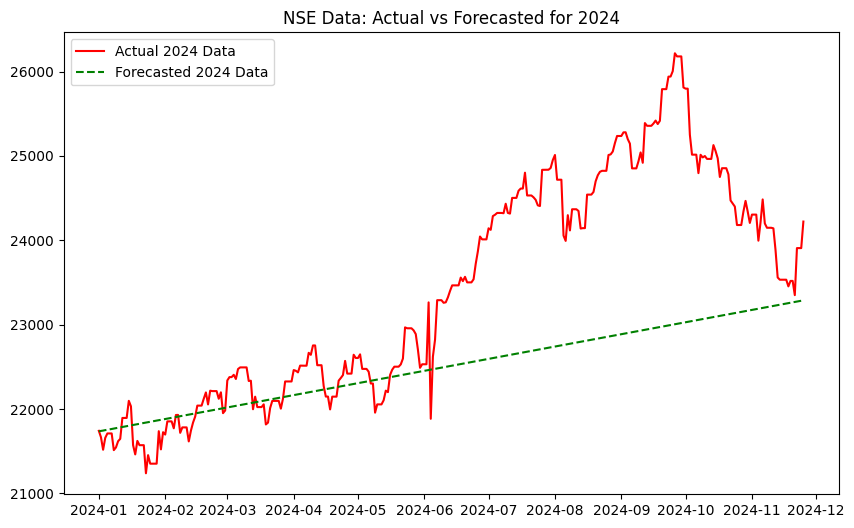

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051


In [ ]:
# Forecast next steps based on the length of the forecast
train_data = df['Close'].dropna()
test_data = df_test['Close']
forecast_steps = len(test_data)

model = ARIMA(train_data, order=(1,2,2))
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_summary = forecast.summary_frame()

forecast_vals = fitted_model.forecast(steps=forecast_steps)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')

# print(forecast_vals)

# Plot forecast
# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
#plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

In [ ]:
# Evaluate the model using error metrics

mae = mean_absolute_error(test_data, forecast_vals)
rmse = np.sqrt(mean_squared_error(test_data, forecast_vals))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 963.4315057277112
Root Mean Squared Error (RMSE): 1298.4844878810527


As observed from the graph, trend is being recognized but its not able to model the seasonality.
Lets try SARIMA and see how it goes.

In [ ]:
seasonal_order = (1, 2, 2, 100)  # 252 trading days in a year (seasonality for daily data)
model = SARIMAX(df['Close'].dropna(), order=(1, 2, 2), seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast the data for 2024 (forecasting steps = length of test data)
forecast_steps = len(df_test['Close'].dropna())
forecast_Values = model_fit.forecast(steps=forecast_steps)

# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
#plt.plot(df.index, train_data, label='Training Data', color='blue')
plt.plot(df_test.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_Values, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packag

KeyboardInterrupt: 

 Though we differenced the data and assumed the process to be stationary, as we have seen that there is still varying component of the Variance with absolute time. Hence, we will not be able to fit a linear model. Hence, lets try ARCH model to fit the data.

In [ ]:
# square the dataset
df['Squared'] = df['Close']**2

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced,Squared
Date,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN,6.265039e+07
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798,6.058054e+07
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337,6.123062e+07
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000,6.123062e+07
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051,6.025253e+07


<Figure size 1200x600 with 0 Axes>

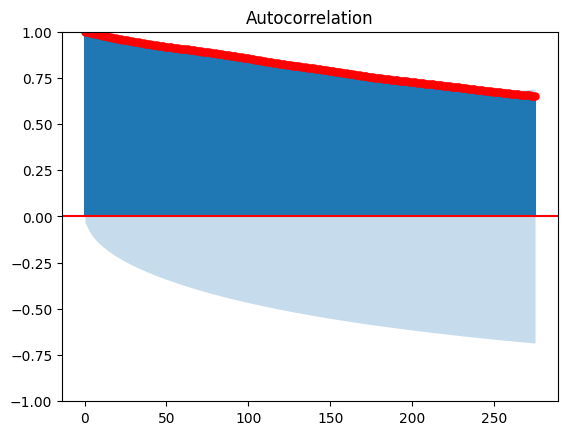

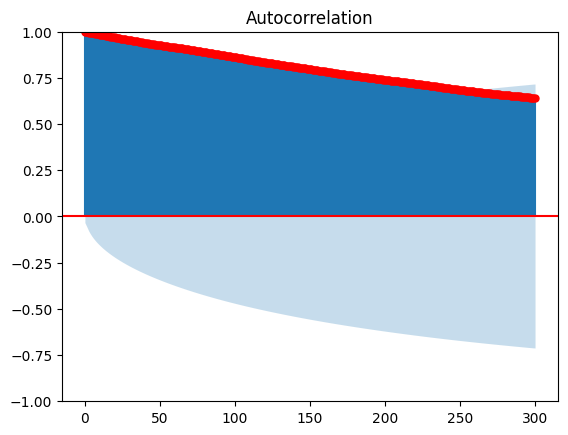

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(df['Squared'].dropna(), lags=275, color = 'red')
plot_acf(df['Close'].dropna(), lags=300, color = 'red')
plt.show()

In [ ]:

train, test = X, Y

model = arch_model(train, mean='Zero', vol='ARCH', p=1)
# fit model
model_fit = model.fit()

print(model_fit.summary())

yhat = model_fit.forecast(horizon=12)
yhat
+

Iteration:      1,   Func. Count:      4,   Neg. LLF: 18206.54518138452
Iteration:      2,   Func. Count:      9,   Neg. LLF: 18028.22127144448
Iteration:      3,   Func. Count:     12,   Neg. LLF: 18028.221169722987
Iteration:      4,   Func. Count:     15,   Neg. LLF: 18028.22116781457
Iteration:      5,   Func. Count:     18,   Neg. LLF: 18028.22115933145
Iteration:      6,   Func. Count:     21,   Neg. LLF: 18028.221107417055
Iteration:      7,   Func. Count:     24,   Neg. LLF: 18028.220847612614
Iteration:      8,   Func. Count:     27,   Neg. LLF: 18028.21976999016
Iteration:      9,   Func. Count:     30,   Neg. LLF: 18028.21450479301
Iteration:     10,   Func. Count:     33,   Neg. LLF: 18028.19553834081
Iteration:     11,   Func. Count:     36,   Neg. LLF: 18028.15893034847
Iteration:     12,   Func. Count:     39,   Neg. LLF: 18028.152185158942
Iteration:     13,   Func. Count:     41,   Neg. LLF: 18028.152185158684
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\mouni\anaconda3\envs\Nifty50\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.118e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
